# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

init_engine()

Using /home/arsenior/Software/spark-1.6.3-bin-hadoop2.6
Adding /home/arsenior/Software/anaconda3/lib/python3.5/site-packages/bigdl/share/lib/bigdl-0.2.0-SNAPSHOT-jar-with-dependencies.jar to SPARK_CLASSPATH
Prepending /home/arsenior/Software/anaconda3/lib/python3.5/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 1))
        return model

    def act(self, state):
        result = self.model.forward(state)
        return 0 if result < 0 else 1

In [3]:
def to_RDD(X, y):
    return sc.parallelize(X).zip(sc.parallelize(y)).map(
            lambda x: Sample.from_ndarray(x[0], x[1]))

In [4]:
def play_n_games(n_games=100):
    memory = []
    actions = []
    results = np.array([])
    for e in range(n_games):
        state = env.reset()
        local_memory = np.array([0,0,0,0])
        local_actions = np.array([])
        for time in range(500):
            #env.render()
            local_memory = np.vstack((local_memory, state))
            action = agent.act(state)
            local_actions = np.append(local_actions, action)
            state, _, done, _ = env.step(action)
            if done or time == 498:
                memory.append(local_memory[1:])
                actions.append(local_actions)
                results = np.append(results, time)
                break
    return memory, actions, results

In [5]:
def games_to_train_data(memory, actions, results, benchmark):
    train_batch = np.array([0,0,0,0])
    train_labels = []
    for local_memory, local_actions, result in zip(memory, actions, results):
        train_batch = np.vstack((train_batch, np.array(local_memory)))
        if result > benchmark:
            local_labels = [-1 if x<=0 else 1 for x in local_actions]
        else:
            local_labels = [1 if x<=0 else -1 for x in local_actions]
        train_labels = np.append(train_labels, local_labels)
    return train_batch[1:], train_labels

In [6]:
env = gym.make('CartPole-v1')
conf = create_spark_conf()
conf.setMaster("local[1]")
sc = SparkContext.getOrCreate(conf)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-09-17 23:36:19,001] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear


In [7]:
record = []
i = 0
benchmark = 0
local_records = []

In [8]:
%%time
while i <= 200:
    i += 1
    memory, actions, results = play_n_games(n_games=50)
    record.append((results.mean(), results.var()))
    print('Current resulst: {}, variance: {}. This is try number: {}'.format(results.mean(), results.var(), i))              
    benchmark = results.mean()
    train_batch, train_labels = games_to_train_data(memory, actions, results, benchmark)
    rdd_sample = to_RDD(train_batch, train_labels)
    if benchmark != 498:
        optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=MSECriterion(),
                                  optim_method=Adam(),
                                  end_trigger=MaxEpoch(1),
                                  batch_size=10)
        trained_model = optimizer.optimize()
        agent.model = trained_model

Current resulst: 8.4, variance: 0.4. This is try number: 1
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
Current resulst: 8.42, variance: 0.5236000000000002. This is try number: 2
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
Current resulst: 8.16, variance: 0.5344. This is try number: 3
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
Current resulst: 8.36, variance: 0.7103999999999999. This is try number: 4
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
Current resulst: 8.3, variance: 0.61. This is try number: 5
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
Current resulst: 8.22, variance: 0.49160000000000004. This is try number: 6
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: cr

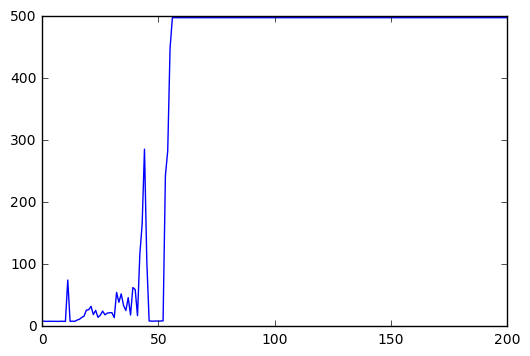

In [9]:
plt.plot([x[0] for x in record])
plt.show()